In [3]:
import pandas as pd
import numpy as np

# -----------------------------------------------------------------------------
# Function: estimate_precipitation_percent
# -----------------------------------------------------------------------------
def estimate_precipitation_percent(temp_c, wind_kmh, humidity_pct):
    """
    Estimate precipitation likelihood as a percentage (0–100%) using gradient-based heuristics.
    This function computes three normalized “scores” (humidity, temperature, wind) in the range [0, 1],
    then combines them via a weighted sum to yield a final precipitation percentage.
    
    Parameters:
    -----------
    temp_c : float
        Air temperature in degrees Celsius.
    wind_kmh : float
        Wind speed in kilometers per hour.
    humidity_pct : float
        Relative humidity as a percentage (0–100).
        
    Returns:
    --------
    float
        Precipitation likelihood as a percentage (0.0 to 100.0), rounded to two decimal places.
    """
    # 1. Compute humidity_score:
    #    - Below 85% humidity contributes zero.
    #    - Between 85% and 100% maps linearly from 0 to 1.
    humidity_score = max(0.0, min((humidity_pct - 85.0) / 15.0, 1.0))
    #    Explanation:
    #    If humidity_pct = 85 → (85 − 85)/15 = 0 → humidity_score = 0
    #    If humidity_pct = 100 → (100 − 85)/15 = 1 → humidity_score = 1
    #    Values above 100% are clipped to 1; values below 85% are clipped to 0.
    
    # 2. Compute temp_score:
    #    - Below 24°C begins contributing precipitation likelihood.
    #    - At or below 14°C (24 − 10), this contribution is maximal (1).
    temp_score = max(0.0, min((24.0 - temp_c) / 10.0, 1.0))
    #    Explanation:
    #    If temp_c = 24 → (24 − 24)/10 = 0 → temp_score = 0
    #    If temp_c = 14 → (24 − 14)/10 = 1 → temp_score = 1
    #    Temperatures below 14°C are clipped to 1; above 24°C are clipped to 0.
    
    # 3. Compute wind_score:
    #    - Below 17 km/h yields zero contribution.
    #    - At or above 37 km/h (17 + 20), contribution is maximal (1).
    wind_score = max(0.0, min((wind_kmh - 17.0) / 20.0, 1.0))
    #    Explanation:
    #    If wind_kmh = 17 → (17 − 17)/20 = 0 → wind_score = 0
    #    If wind_kmh = 37 → (37 − 17)/20 = 1 → wind_score = 1
    #    Speeds below 17 km/h clipped to 0; above 37 km/h clipped to 1.
    
    # 4. Weighted combination:
    #    - Humidity and temperature each contribute up to 40% of the final score.
    #    - Wind contributes up to 20% of the final score.
    #    - Maximum possible weighted_score = 40*1 + 40*1 + 20*1 = 100.
    weighted_score = (50.0 * humidity_score) + (30.0 * temp_score) + (20.0 * wind_score)
    
    # 5. Convert to percentage and round:
    precipitation_pct = int(weighted_score * 1.5)

    if precipitation_pct > 100:
        precipitation_pct = 100

    return precipitation_pct


# -----------------------------------------------------------------------------
# Step 0: Define file paths and severe-weather time window
# -----------------------------------------------------------------------------
input_path = "Data/Raw/Wollongong_Weather__10_20_Jan_2025_from_TimeandDate.csv"
output_path = "Data/Exp/ProcessedData_Wollongong_Weather__10_20_Jan_2025.csv"

# Define the severe weather period (inclusive) so we can treat it differently later.
# This is the timeframe when we expect elevated precipitation and do not scale down.
SEVERE_START = pd.Timestamp("2025-01-15 12:20")
SEVERE_END   = pd.Timestamp("2025-01-18 22:59")


# -----------------------------------------------------------------------------
# Step 1: Load raw weather data and parse timestamps
# -----------------------------------------------------------------------------
# We assume the CSV has at least these columns:
#   - 'Timestamp'      (datetime string)
#   - 'Temperature_C'  (float)
#   - 'Wind_km_h'      (float)
#   - 'Humidity_%'     (float)
#
# parse_dates ensures that 'Timestamp' is converted into a pandas.Timestamp.
df = pd.read_csv(input_path, parse_dates=['Timestamp'])


# -----------------------------------------------------------------------------
# Step 2: Estimate precipitation percentage for each timestamp
# -----------------------------------------------------------------------------
# Create a new column 'Precipitation_%' by applying our gradient-based function.
df['Precipitation_%'] = df.apply(
    lambda row: estimate_precipitation_percent(
        temp_c=row['Temperature_C'],
        wind_kmh=row['Wind_km_h'],
        humidity_pct=row['Humidity_%']
    ),
    axis=1
)
# At this point, 'Precipitation_%' is a value from 0.00 to 100.00 for each row.


# -----------------------------------------------------------------------------
# Step 3: Smooth the precipitation percentage with a centered moving average
# -----------------------------------------------------------------------------
# We use a 7-point window (≈3 hours on either side if data is hourly).
# center=True ensures the average is centered at each data point.
# min_periods=1 means that near edges (where fewer than 7 points exist), it will average
# whatever points are available.
df['Precipitation_%'] = (
    df['Precipitation_%']
    .rolling(window=3, center=True, min_periods=1)
    .mean()
    .round(2)
)


# -----------------------------------------------------------------------------
# Step 4: Scale down values outside the severe weather period
# -----------------------------------------------------------------------------
# Rationale:
#   - Outside the severe weather window, large spikes in precipitation_% may be
#     unrealistic. We will find the maximum observed precipitation_% outside the severe window.
#   - If that maximum exceeds 35%, we scale all outside values so that the new maximum is 14%.
#   - After scaling, any value below 7% is considered negligible and set to 0%.
#
# First, identify the maximum precipitation_% outside the severe-window.
mask_outside = (df['Timestamp'] < SEVERE_START) | (df['Timestamp'] > SEVERE_END)
max_outside_pct = df.loc[mask_outside, 'Precipitation_%'].max()

def scale_outside_severe(row):
    """
    For timestamps outside the severe window, scale the smoothed precipitation_%
    if the maximum outside % > 35. Then zero-out small values (< 7%).
    Inside the severe window, return the original smoothed percentage unchanged.
    """
    timestamp = row['Timestamp']
    pct_value = row['Precipitation_%']
    
    # Check if this row is outside the severe window:
    if (timestamp < SEVERE_START) or (timestamp > SEVERE_END):
        if max_outside_pct > 25.0:
            # Scale so that the previous max_outside_pct maps to 14% maximum
            scaled = pct_value * (20.0 / max_outside_pct)
        else:
            # If max_outside_pct ≤ 35%, do not scale; keep pct_value as-is
            scaled = pct_value
        
        # If the scaled value is below 7%, treat as no precipitation (0.0%)
        if scaled < 5.0:
            return 0.0
        else:
            return round(scaled, 2)
    
    # During the severe window, return the smoothed percentage unchanged
    return pct_value

# Apply the scaling function
df['Precipitation_%'] = df.apply(scale_outside_severe, axis=1)


# -----------------------------------------------------------------------------
# Step 5: Re-apply smoothing to ensure no abrupt edges after scaling
# -----------------------------------------------------------------------------
# It’s useful to smooth again so that any discontinuities introduced by scaling are dampened.
df['Precipitation_%'] = (
    df['Precipitation_%']
    .rolling(window=3, center=True, min_periods=1)
    .mean()
    .round(2)
)


# -----------------------------------------------------------------------------
# Step 6: Drop 'Precipitation_mm' and Save the processed DataFrame to CSV
# -----------------------------------------------------------------------------
df.drop(columns=['Precipitation_mm'], inplace=True)
df.to_csv(output_path, index=False)

# ----------------------------------- END -------------------------------------


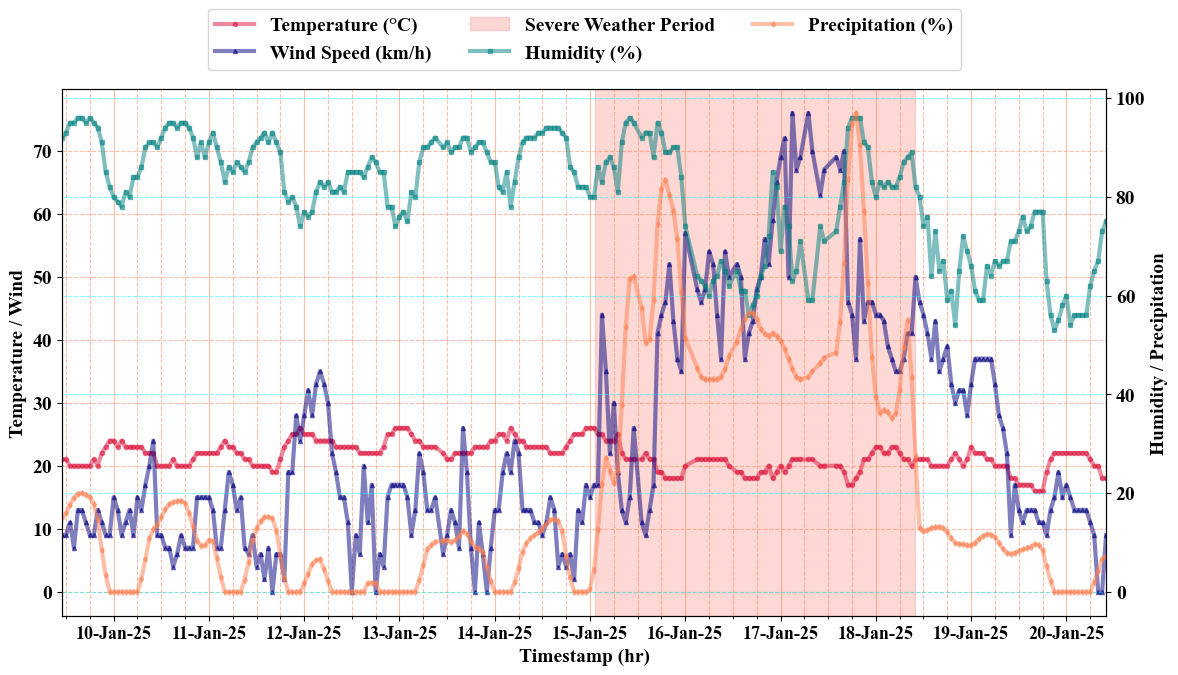

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set font globally
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams["font.weight"] = "bold"

# Load the processed dataset with parsed timestamps
file_path = "Data/Exp/ProcessedData_Wollongong_Weather__10_20_Jan_2025.csv"
df = pd.read_csv(file_path, parse_dates=['Timestamp'])

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot temperature, wind speed
ax1.plot(
    df['Timestamp'],
    df['Temperature_C'],
    label='Temperature (°C)',
    color='crimson',
    linewidth=3,
    marker='o',
    markersize=3,
    alpha=0.5
)
ax1.plot(
    df['Timestamp'],
    df['Wind_km_h'],
    label='Wind Speed (km/h)',
    color='navy',
    linewidth=3,
    marker='^',
    markersize=3,
    alpha=0.5
)

# Plot humidity and precipitation on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(
    df['Timestamp'],
    df['Humidity_%'],
    label='Humidity (%)',
    color='teal',
    linewidth=3,
    marker='s',
    markersize=3,
    alpha=0.5
)
ax2.plot(
    df['Timestamp'],
    df['Precipitation_%'],
    label='Precipitation (%)',
    color='coral',
    linewidth=3,
    marker='d',
    markersize=3,
    alpha=0.5
)

# Axis labels
ax1.set_xlabel('Timestamp (hr)', fontweight='bold')
ax1.set_ylabel('Temperature / Wind', fontweight='bold')
ax2.set_ylabel('Humidity / Precipitation', fontweight='bold')

# 1. Major ticks at 12:00 each day (so "10 Jan 2025" appears at midday)
ax1.xaxis.set_major_locator(mdates.HourLocator(byhour=12+1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))

# 2. Minor ticks = every 6 hours
ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=6))

# 3. Vertical grid lines at every 6h (minor ticks)
ax1.grid(which='minor', linestyle='--', color='coral', alpha=0.5)

# 3a. Horizontal grid lines at each y‐major tick
ax1.grid(which='major', axis='y', linestyle='--', color='coral', alpha=0.5)

ax2.grid(which='major', axis='y', linestyle='--', color='cyan', alpha=0.5)

# 4. Ensure no grid at x‐major ticks
ax1.grid(which='major', axis='x', color='coral', alpha=0.5, visible=True)

# 5. Fix x‐axis range: Jan 10 00:00 → Jan 20 23:00
start = pd.Timestamp("2025-01-10 00:00")
end   = pd.Timestamp("2025-01-20 23:00")
ax1.set_xlim(start, end)

# 6. Keep x‐axis labels horizontal & set font size
ax1.tick_params(axis='x', rotation=0, labelsize=13)

# Remove or comment out this line so labels stay horizontal:
# fig.autofmt_xdate()

# Shade 15–19 Jan as severe weather
ax1.axvspan(
    pd.Timestamp("2025-01-15 14:20"),
    pd.Timestamp("2025-01-18 22:59"),
    color='salmon',
    alpha=0.3,
    label='Severe Weather Period'
)

# Merge legends from both axes + shaded patch
lines, labels   = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines + lines2,
    labels + labels2,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.17),
    ncol=3,
    frameon=True
)

plt.tight_layout()
plt.savefig(
    "Figures/Wollongong_Weather_10_20_Jan_2025.png",
    dpi=600,
    bbox_inches='tight'
)
# plt.show()
